In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal
import cartopy.crs as ccrs
import cmaps
import cartopy.feature as cf
import cmocean

In [2]:

def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): Th type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt



In [3]:
#LOAD DATA

tropical_glorys_clim       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_tropical.nc').drop('sst')
coastnorth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastnorth.nc').drop('sst')
coastsouth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastsouth.nc').drop('sst')

tropical_glorys       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_tropical.nc').convert_calendar('noleap', dim='time').drop('sst')
tropical_glorys       = (tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim).convert_calendar('gregorian').drop('dayofyear')
coastsouth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastsouth.nc').convert_calendar('noleap', dim='time').drop('sst')
coastsouth_glorys     = (coastsouth_glorys.groupby('time.dayofyear')-coastsouth_glorys_clim).convert_calendar('gregorian').drop('dayofyear')


tropical_reforecast_clim   = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_tropical_clim.nc')
coastsouth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastsouth_clim.nc')

tropical_reforecast   = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_tropical.nc').convert_calendar('noleap', dim='inittime')
tropical_reforecast   = (tropical_reforecast.groupby('inittime.dayofyear')-tropical_reforecast_clim).convert_calendar('gregorian', dim='inittime').drop('dayofyear').drop_duplicates(
                    'inittime').interp({'inittime':coastsouth_glorys.time.values}).bfill('inittime').ffill('inittime')

coastsouth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastsouth.nc').convert_calendar('noleap', dim='inittime')
coastsouth_reforecast = (coastsouth_reforecast.groupby('inittime.dayofyear')-coastsouth_reforecast_clim).convert_calendar('gregorian', dim='inittime').drop('dayofyear').drop_duplicates(
                    'inittime').interp({'inittime':coastsouth_glorys.time.values}).bfill('inittime').ffill('inittime')

In [4]:
south_glorys = xr.concat([tropical_glorys, coastsouth_glorys
                         ],'index')

south_reforecast = xr.concat([tropical_reforecast,coastsouth_reforecast
                         ],'index')

In [7]:
kwindex = pd.read_csv('kw_index_nrt.csv', index_col=0, parse_dates=True).iloc[:,0]


In [17]:
zones_south = {'NorthPeru':slice(-4,-8),
               'SouthPeru':slice(-13,-16),
               'Atacama':slice(-21,-25),
               'CentralChile':slice(-29,-31)}

zsouth_reforecast  = {keys:south_reforecast.swap_dims({'index':'lat'}).sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}
zsouth_glorys      = {keys:south_glorys.swap_dims({'index':'lat'}).sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}

In [246]:
z = 'NorthPeru'
reference = zsouth_glorys[z]
forecast  = zsouth_reforecast[z]
zos_skill    = []
T300_skill   = []
for i,time in enumerate(reference.time[:-46]):
    if i%100==0:
        print(time.values)
    x = reference.sel(time=slice(time.values,time.values+pd.Timedelta(days=45)))
    x.coords['leadtime'] = ('time',range(len(x.time)))
    x = x.swap_dims({'time':'leadtime'}).drop('time')
    y = forecast.sel(inittime=time)

    zos_skill.append(xr.corr(x.zos,y.zos,'leadtime').item())
    T300_skill.append(xr.corr(x.T300,y.T300,'leadtime').item())

zos_skill  = pd.Series(zos_skill,index=kwindex.index[:-46])**2
T300_skill = pd.Series(T300_skill,index=kwindex.index[:-46])**2

2000-01-01T12:00:00.000000000
2000-04-11T12:00:00.000000000
2000-07-20T12:00:00.000000000
2000-10-28T12:00:00.000000000
2001-02-05T12:00:00.000000000
2001-05-16T12:00:00.000000000
2001-08-24T12:00:00.000000000
2001-12-02T12:00:00.000000000
2002-03-12T12:00:00.000000000
2002-06-20T12:00:00.000000000
2002-09-28T12:00:00.000000000
2003-01-06T12:00:00.000000000
2003-04-16T12:00:00.000000000
2003-07-25T12:00:00.000000000
2003-11-02T12:00:00.000000000
2004-02-10T12:00:00.000000000
2004-05-21T12:00:00.000000000
2004-08-29T12:00:00.000000000
2004-12-07T12:00:00.000000000
2005-03-17T12:00:00.000000000
2005-06-25T12:00:00.000000000
2005-10-03T12:00:00.000000000
2006-01-11T12:00:00.000000000
2006-04-21T12:00:00.000000000
2006-07-30T12:00:00.000000000
2006-11-07T12:00:00.000000000
2007-02-15T12:00:00.000000000
2007-05-26T12:00:00.000000000
2007-09-03T12:00:00.000000000
2007-12-12T12:00:00.000000000
2008-03-22T12:00:00.000000000
2008-06-30T12:00:00.000000000
2008-10-08T12:00:00.000000000
2009-01-16

Text(0.5, 1.0, 'Example of a bad forecast:\n$R^2$ = 0.00\n KW Index = -0.58')

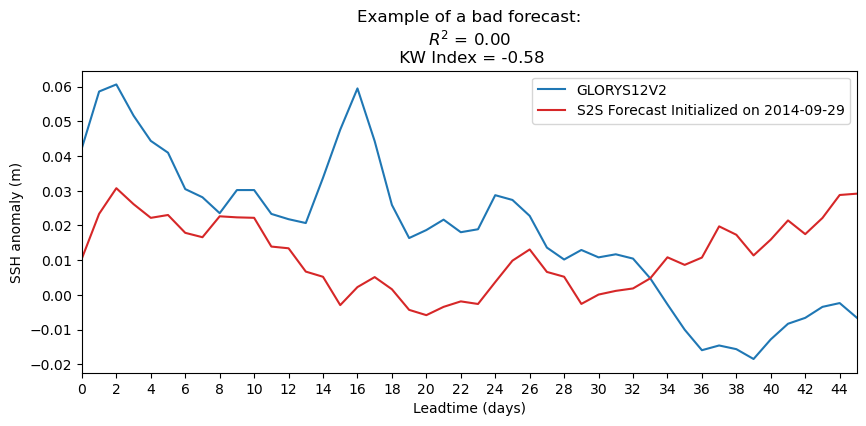

In [237]:
plt.figure(figsize=(10,4), facecolor='w', dpi=100)
date = '2014-09-29'
plt.plot(reference.sel(time=slice(pd.to_datetime(date),pd.to_datetime(date)+pd.Timedelta(days=46))).zos, color='tab:blue', label='GLORYS12V2');
plt.plot(forecast.sel(inittime=date).zos.squeeze().values, color='tab:red',label='S2S Forecast Initialized on {}'.format(date));
plt.xlim(0,45)
plt.xticks(np.arange(0,45,2));
plt.xlabel('Leadtime (days)')
plt.ylabel('SSH anomaly (m)')
plt.legend()
plt.title('Example of a bad forecast:\n$R^2$ = {:.2f}\n KW Index = {:.2f}'.format(zos_skill.loc[date].item(), kwindex[date].item()))

Text(1.0, 1.0, 'NorthPeru skill')

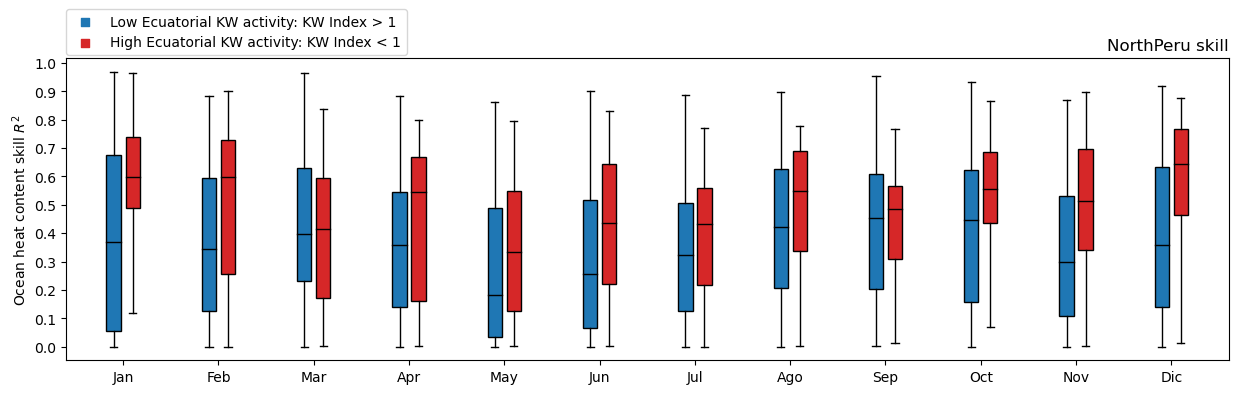

In [247]:

fig, ax = plt.subplots(1,1, figsize=(15,4), facecolor='w', dpi=100)
for i,g in zos_skill.groupby(zos_skill.index.month):
    
    ax.boxplot(g.where(kwindex.loc[g.index]>1).dropna(), positions=[i+0.1], sym='', patch_artist=True, medianprops=dict(color='k'), boxprops=dict(facecolor='tab:red'))
    ax.boxplot(g.where(kwindex.loc[g.index]<1).dropna(), positions=[i-0.1], sym='', patch_artist=True, medianprops=dict(color='k'), boxprops=dict(facecolor='tab:blue'))
    
    
ax.scatter([],[], marker='s', color='tab:blue', label='Low Ecuatorial KW activity: KW Index > 1')
ax.scatter([],[], marker='s', color='tab:red', label='High Ecuatorial KW activity: KW Index < 1')
ax.set_ylabel('Ocean heat content skill $R^2$')
ax.set_yticks(np.arange(0,1+0.1,0.1))
ax.set_xticks(range(1,12+1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
ax.legend(loc=(0,1.01))
ax.set_title('{} skill'.format(z),loc='right')